In [1]:
import serial
from struct import *

%matplotlib notebook
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
from datetime import datetime

PAYLOAD_STC_FORMAT = '<BHhhhhhhB'
PAYLOAD_SIZE = 16

In [2]:
s = serial.Serial('COM4', 250000)

In [3]:
class SensorData():
    def __init__(self, id, t, accX, accY, accZ, gyroX, gyroY, gyroZ):
        self.__id  = id
        self.__temperature = t
        self.__acc = [accX, accY, accZ]
        self.__gyro = [gyroX, gyroY, gyroZ]
        
    def temperature_from_raw(self, t):
        return t * 0.00390625

    def acc_from_raw(self, d):
        #(float)in * 0.061 * (8 >> 1) / 1000.0;
        return d * 0.061 * 4.0 / 1000.0

    def dps_from_raw(self, d):
        #(float)in * 4.375 * (2000 / 125) / 1000.0;
        return d * 4.375 * 16 / 1000.0
        
    @property
    def id(self):
        return self.__id
    
    @property
    def temperature(self):
        return self.temperature_from_raw(self.__temperature)
    
    @property
    def acc(self):
        return [self.acc_from_raw(x) for x in self.__acc]
    
    @property
    def gyro(self):
        return [self.dps_from_raw(x) for x in self.__gyro]

In [4]:
def compute_crc(data):
    crc = 0x00
    for c in data[:-1]:
        crc = crc ^ c
        for i in range(0, 8):
            if crc & 0x01:
                crc  = (crc >> 1) ^ 0x8c
            else:
                crc = crc >> 1
    return crc

<IPython.core.display.Javascript object>


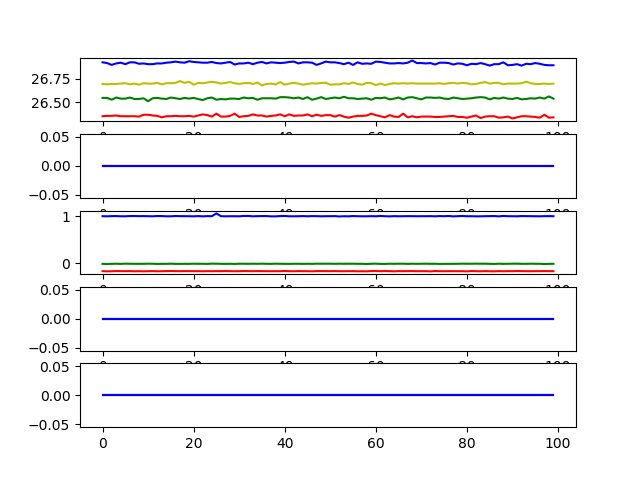

Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum
Bad checksum

IndexError: list index out of range

In [5]:
fig = plt.figure()
grid = plt.GridSpec(5, 4, hspace = 0.2)

ax_temp = fig.add_subplot(grid[0, :])
#ax_gyro = fig.add_subplot(grid[0, 2])



ax_temp_window = [ {'data': [0] * 100, 'format': 'r', 'args': {'label': 'Sensor 1'}},
                   {'data': [0] * 100, 'format': 'g', 'args': {'label': 'Sensor 2'}},
                   {'data': [0] * 100, 'format': 'b', 'args': {'label': 'Sensor 3'}},
                   {'data': [0] * 100, 'format': 'y', 'args': {'label': 'Sensor 4'}}
                 ]

ax_acc_window = [ { 'plot': fig.add_subplot(grid[1, :]), 'axis': [ {'data': [0] * 100, 'format': 'r'},{'data': [0] * 100, 'format': 'g'},{'data': [0] * 100, 'format': 'b'}]},
                  { 'plot': fig.add_subplot(grid[2, :]), 'axis': [ {'data': [0] * 100, 'format': 'r'},{'data': [0] * 100, 'format': 'g'},{'data': [0] * 100, 'format': 'b'}]},
                  { 'plot': fig.add_subplot(grid[3, :]), 'axis': [ {'data': [0] * 100, 'format': 'r'},{'data': [0] * 100, 'format': 'g'},{'data': [0] * 100, 'format': 'b'}]},
                  { 'plot': fig.add_subplot(grid[4, :]), 'axis': [ {'data': [0] * 100, 'format': 'r'},{'data': [0] * 100, 'format': 'g'},{'data': [0] * 100, 'format': 'b'}]} 
                ]

ax_gyro_window = [0] * 100

plt.ion()
fig.show()
fig.canvas.draw()

for w in ax_temp_window:
    ax_temp.plot(w['data'], w['format'], **w['args'])

ax_temp.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
    
for w in ax_acc_window:
    p = w['plot']
    for a in w['axis']:
        p.plot(a['data'], a['format'])

#ax_gyro.plot(ax_gyro_window)

t_start = datetime.utcnow()

while True:
    c = s.read(1)
    if c == b'%':
        data = s.read(PAYLOAD_SIZE)
        crc = compute_crc(data)
        unpacked = unpack(PAYLOAD_STC_FORMAT, data)
        
        if unpacked[-1] == crc:
            sensorData = SensorData(*unpacked[:-1])
            ax_temp_window[sensorData.id]['data'].pop(0)
            ax_temp_window[sensorData.id]['data'].append(sensorData.temperature)
            
            acc = sensorData.acc
            ax_acc_window[sensorData.id]['axis'][0]['data'].pop(0)
            ax_acc_window[sensorData.id]['axis'][0]['data'].append(acc[0])
            ax_acc_window[sensorData.id]['axis'][1]['data'].pop(0)
            ax_acc_window[sensorData.id]['axis'][1]['data'].append(acc[1])
            ax_acc_window[sensorData.id]['axis'][2]['data'].pop(0)
            ax_acc_window[sensorData.id]['axis'][2]['data'].append(acc[2])
        else:
            print('Bad checksum')

    t_now = datetime.utcnow()
    if (t_now - t_start).total_seconds() > 0.1:
        ax_temp.clear()
        
        for w in ax_temp_window:
            ax_temp.plot(w['data'], w['format'], **w['args'])
        ax_temp.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
        
        for w in ax_acc_window[1:2]:
            p = w['plot']
            p.clear()
            for a in w['axis']:
                p.plot(a['data'], a['format'])

        
        fig.canvas.draw()
        time.sleep(0.0001)
        t_start = t_now

In [ ]:
s.close()